# Hypothesis Testing

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

# globally set larger axes font size for all plots
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18

---
## **Example 1. One-sample t-Test against known mean.**

## A colony of mice with a genetic mutation have a mean life expectancy of 80 days. You give 30 mice an experimental drug and record their lifetimes (see below).

In [2]:
lifetimes = st.norm.rvs(loc=85, scale=10, size=30, random_state=1)

### **Null hypothesis (H0)**: Drug has no effect on mean lifetime, i.e. subject lifetimes come from a population with mean equal to 80 days.

### **Alternative hypothesis (Ha)**: Drug has an effect on mean lifetime, i.e. subject lifetimes come from a population with mean NOT equal to 80 days.

### Are the data normally distributed?

e.g., see [this example guide](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)

1. **Visual check**
2. Statistical check

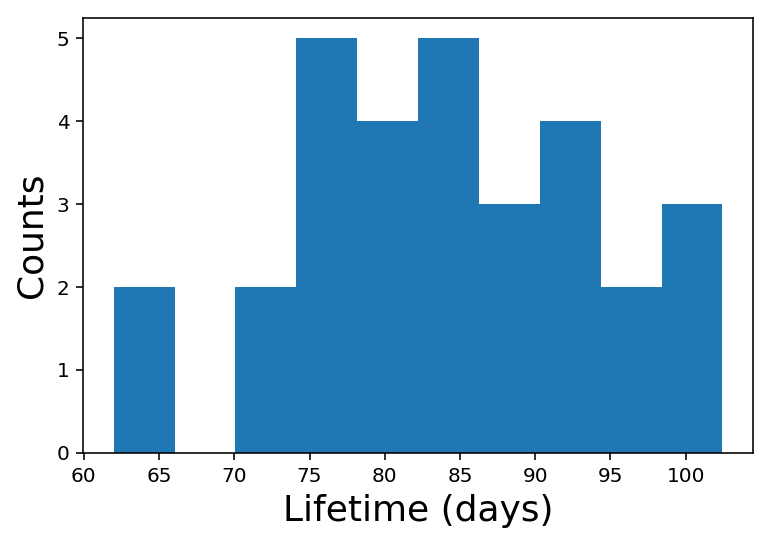

In [4]:
plt.hist(lifetimes)
plt.xlabel('Lifetime (days)')
plt.ylabel('Counts');

### Are the data normally distributed?

1. Visual check
2. **Statistical check**

In [12]:
stat, pvalue = st.normaltest(lifetimes)

print(f"p-value for the null hypothesis (H0) that data are normally distributed is {pvalue :.3f}")

if pvalue < 0.05:
    print("Reject H0. Data are NOT normally distributed")
else:
    print("Do NOT reject H0. Data are normally distributed")

p-value for the null hypothesis (H0) that data are normally distributed is 0.897
Do NOT reject H0. Data are normally distributed


Note, there are multiple different checks for normality. I've only introduced one of them. Ideally, your data should pass all checks if it is indeed normal. Alternatively, if it passes some but not all checks, then you might consider it to be normal-ish, which may be ok to treat as normal in some circumstances.

### Plot the lifetimes of the 30 experimental subjects overlaid with MLE of their normal distribution.

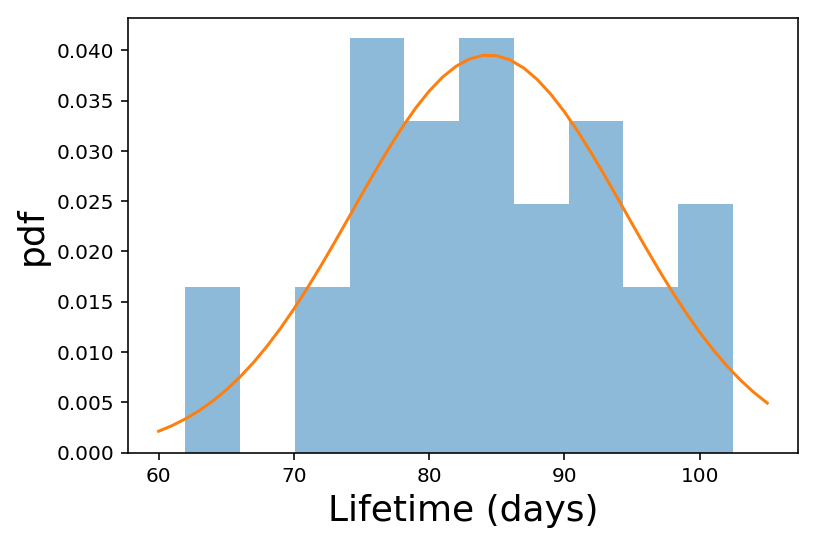

In [19]:
plt.hist(lifetimes, density=True, alpha=0.5)
plt.xlabel('Lifetime (days)')
plt.ylabel('pdf')

# MLE normal dist for data
mu, sd = st.norm.fit(lifetimes)
normDist = st.norm(mu, sd)

days = np.arange(60, 106)
plt.plot(days, normDist.pdf(days));

### Plot the lifetimes of the 30 experimental subjects overlaid with expected distribution for the sample mean and ...

### indicate the mean and 95% confidence interval of the mean.

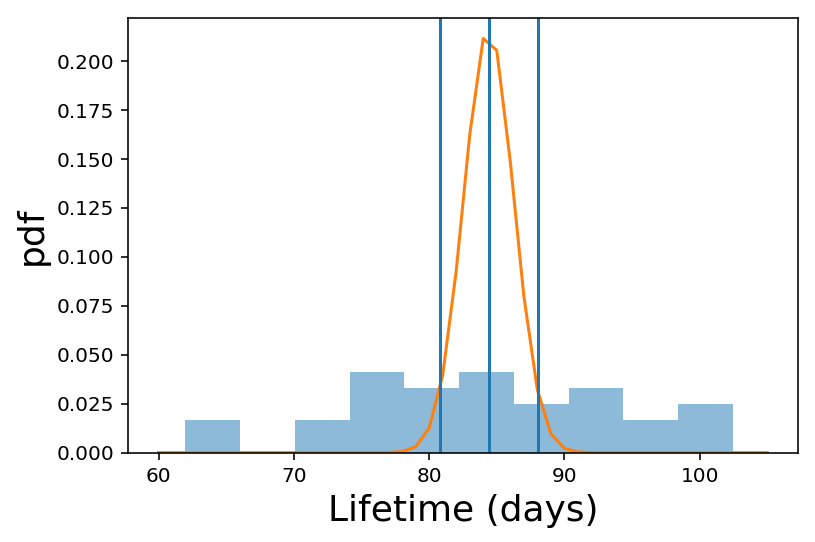

In [87]:
plt.hist(lifetimes, density=True, alpha=0.5)
plt.xlabel('Lifetime (days)')
plt.ylabel('pdf')

# dist for mean
sampleMeanDist = st.norm(mu, sd / np.sqrt(30))

days = np.arange(60, 106)
plt.plot(days, sampleMeanDist.pdf(days))

# mean and 95% confidence interval about the mean
plt.axvline(mu)
plt.axvline(sampleMeanDist.ppf(0.025))
plt.axvline(sampleMeanDist.ppf(0.975));

### Which statistical test to use?

Given that the data are normally distributed, we can use a one sample t-test vs. the known mean for our statistical test.

### Apply test to obtain a p-value.

In [93]:
t, p = st.ttest_1samp(lifetimes, 80)
print(f"p-value for H0 (drug has no effect on mean lifetime) is {p :.4f}")

p-value for H0 (drug has no effect on mean lifetime) is 0.0259


### Do we reject the null hypothesis?

Yes, reject $H_0$ as $p < 0.05$.

### Does the drug have an effect on mean lifetime?

Yes

### What is the size of the drug's effect?

[Effect Size](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444174/)

"Statistical significance is the least interesting thing about the results. You should describe the results in terms of measures of magnitude not just, does a treatment affect people, but how much does it affect them." *-Gene V. Glass*

"The primary product of a research inquiry is one or more measures of effect size, not P values." *-Jacob Cohen*

**Very small differences, even if significant, are often meaningless.**

One way to quantify effect size is **Cohen's d**, which is the difference in means divided by the standard deviation.

In [91]:
effectSize = (lifetimes.mean() - 80) / lifetimes.std()
effectSize

0.4360865581406126

### Does the drug have a meaningful effect on mean lifetime?

The effect is modest in comparison to the variation, so one might conclude that this effect is not big enough to matter much. However, this of course depends on how impactful a small average effect is.

### What is our power to detect an effect of the drug given our observed effect size with 30 observations?

https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

![Power](images/power.png)

In [92]:
import statsmodels.stats.power as smp

power = smp.tt_solve_power(effect_size=effectSize, nobs=30, alpha=0.05, alternative='two-sided')

print(f"Our power to detect an effect of the drug on the mean lifetime of a sample of 30 individuals is {power :.2f}")

Our power to detect an effect of the drug on the mean lifetime of a sample of 30 individuals is 0.64


#### This means that given a bunch of random samples, each with 30 individuals, we would only expect to determine that the drug had an effect in 64% of the samples.

If we assume that 30 random samples form the population without drug will have a similar standard deviation, we can visualize the power calculation.

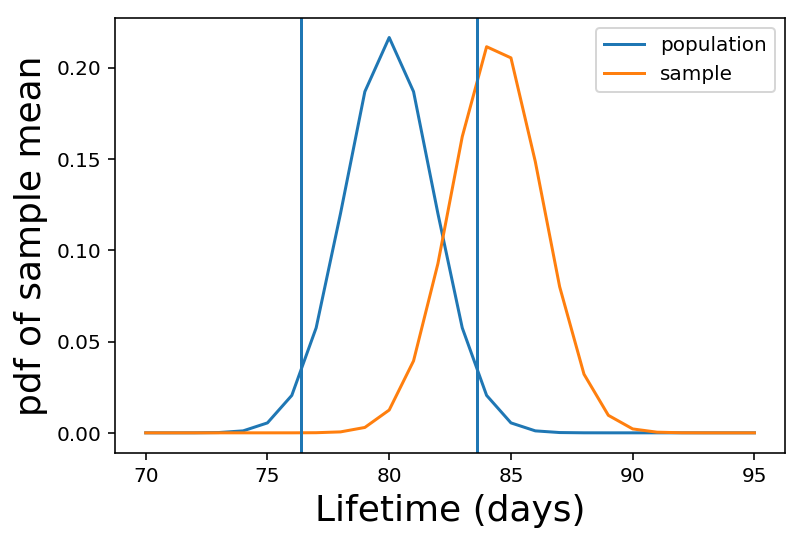

In [88]:
populationMeanDist = st.norm(80, lifetimes.std() / np.sqrt(30))

days = np.arange(70, 96)

plt.plot(days, populationMeanDist.pdf(days), label='population')
plt.plot(days, sampleMeanDist.pdf(days), label='sample')
plt.axvline(populationMeanDist.ppf(0.025))
plt.axvline(populationMeanDist.ppf(0.975))
plt.xlabel('Lifetime (days)')
plt.ylabel('pdf of sample mean')
plt.legend();

### How many individuals would we need to test in a given sample in order to have a power of 0.8 for detecting an effect of the drug on mean lifetime?

In [60]:
numSamples = smp.tt_solve_power(effect_size=effectSize, power=0.8, alpha=0.05, alternative='two-sided')

print(f"For a power of 0.8 we would need to collect {numSamples :.1f} samples.")

For a power of 0.8 we would need to collect 43.2 samples.


#### Thus, we would need to test 44 individuals in order to have at least an 80% chance of detecting the deffect of the drug on mean lifetime.

---
## **Example 2. Two independent samples t-Test.**

## For the same colony as above, do life expectancies differ between females and males?

In [21]:
female_lifetimes = st.norm.rvs(loc=82, scale=10, size=30, random_state=1)
male_lifetimes = st.norm.rvs(loc=79, scale=10, size=30, random_state=80)

### **Null hypothesis (H0)**: Sex has no effect on lifetime.

### **Alternative hypothesis (Ha)**: Sex has an effect on lifetime.

### Plot the lifetimes.

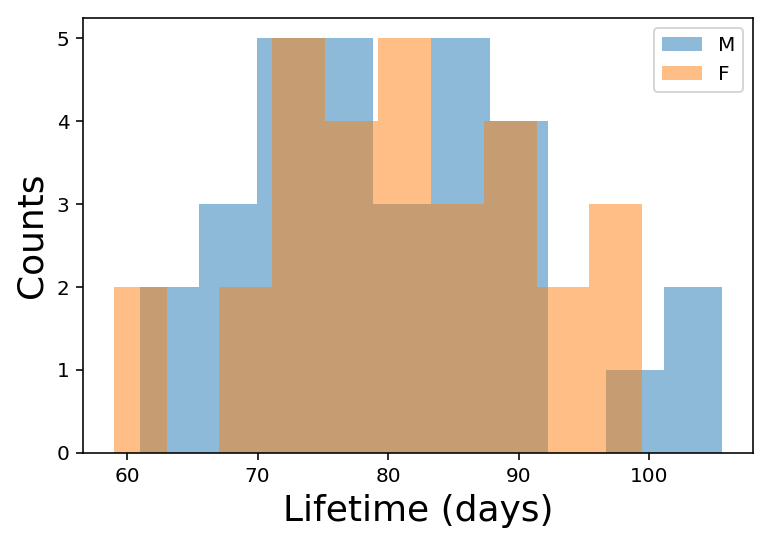

In [22]:
plt.hist(male_lifetimes, alpha=0.5, label='M')
plt.hist(female_lifetimes, alpha=0.5, label='F')
plt.xlabel('Lifetime (days)')
plt.ylabel('Counts')
plt.legend();

### Normality test.

In [24]:
stat, m_pvalue = st.normaltest(male_lifetimes)
stat, f_pvalue = st.normaltest(female_lifetimes)

m_pvalue, f_pvalue

(0.5854627331109816, 0.8973076299656254)

 ## What statistical test should we use?
 
 Two independent samples t-test.
 
 ## Apply test to obtain a p-value.

In [25]:
t, p = st.ttest_ind(female_lifetimes, male_lifetimes)
print(f"p-value for H0 (life expectancy is the same for males and females) is {p :.4f}")

p-value for H0 (life expectancy is the same for males and females) is 0.6357


### Do we reject the null hypothesis?

No, we do NOT reject $H_0$ as $p > 0.05$.

### Does male and female life expectancy differ?

Not that we can tell.

### Power

No effect, so no need to test power. However, if we did we would use `smp.tt_ind_solve_power` for independent samples.

---
## **Example 3. Paired samples t-Test**

## For the same colony as above, does the drug have an effect on a memory recall task? Compare task scores for mice before and after recieving the drug.

In [26]:
before_scores = st.norm.rvs(loc=115, scale=20, size=30, random_state=7)
after_scores = before_scores + st.norm.rvs(loc=-10, scale=10, size=30, random_state=3)

### **Null hypothesis (H0)**: Drug has no effect on task score.

### **Alternative hypothesis (Ha)**: Drug has an effect on task score.

### Plot the before and after score distributions.

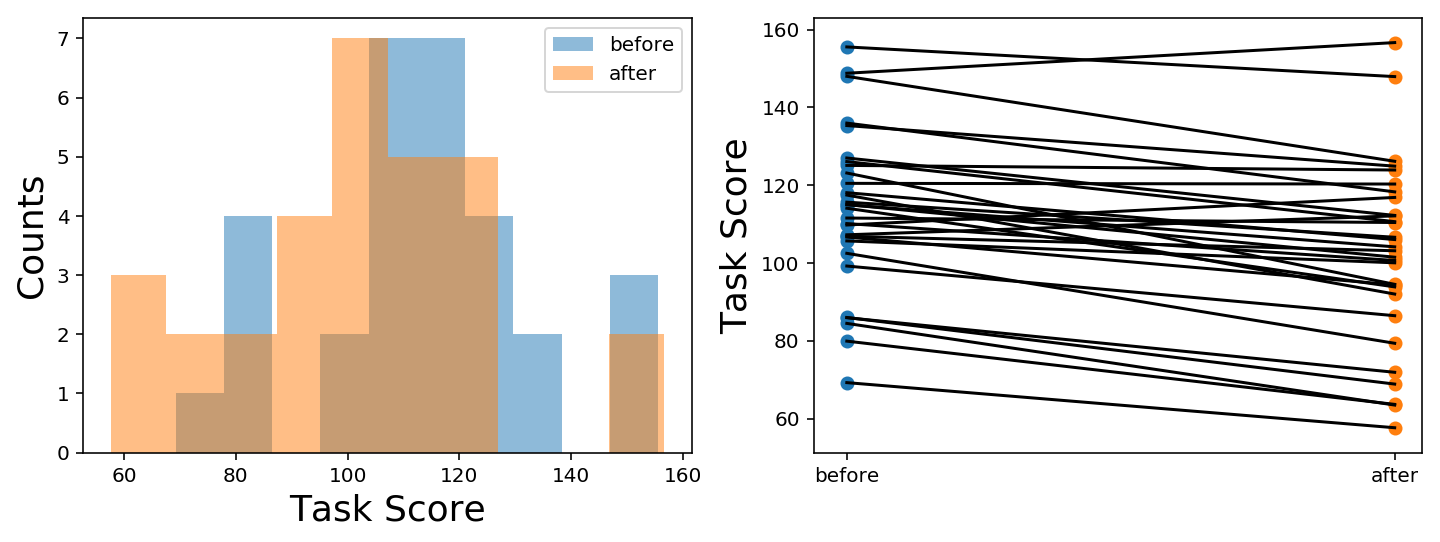

In [28]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.hist(before_scores, alpha=0.5, label='before')
plt.hist(after_scores, alpha=0.5, label='after')
plt.xlabel('Task Score')
plt.ylabel('Counts')
plt.legend();

plt.subplot(1, 2, 2)
plt.scatter(np.zeros(len(before_scores)), before_scores, label='before')
plt.scatter(np.ones(len(after_scores)), after_scores, label='after')
for i in range(len(before_scores)):
    plt.plot([0, 1], [before_scores[i], after_scores[i]], 'k')
plt.xticks([0, 1], ['before', 'after'])
plt.ylabel('Task Score');

### Normality test.

In [29]:
stat, b_pvalue = st.normaltest(before_scores)
stat, a_pvalue = st.normaltest(after_scores)

b_pvalue, a_pvalue

(0.9110072983068402, 0.8766423673340311)

 ## What statistical test should we use?
 
 Two related samples t-test.
 
 ## Apply test to obtain a p-value.

In [32]:
t, p = st.ttest_rel(before_scores, after_scores)
print(f"p-value for H0 (drug noes NOT affect task score) is {p}")

p-value for H0 (drug noes NOT affect task score) is 2.637607974903502e-07


### Do we reject the null hypothesis?

Yes, we reject $H_0$ as $p < 0.05$.

### Does the drug affect ability in the memory recall task?

Yes

### What is the size of the drug's effect?

Cohen's d effect size is -1.24


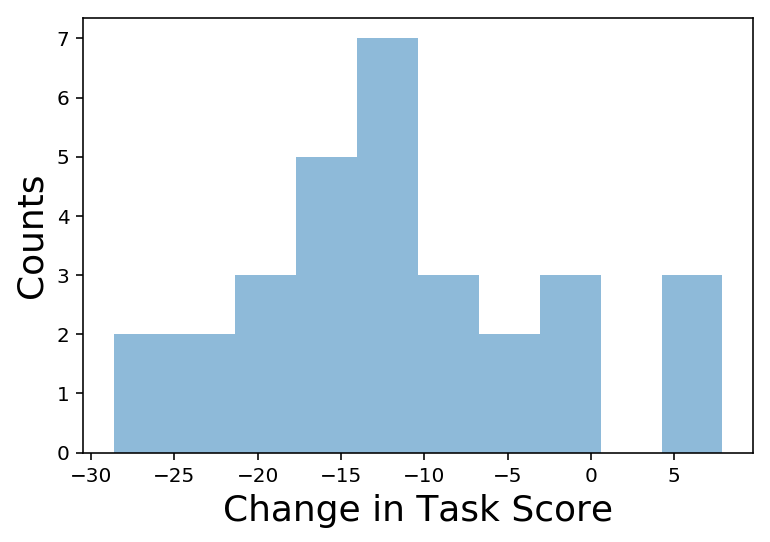

In [74]:
score_change = after_scores - before_scores

effectSize = score_change.mean() / score_change.std()

print(f"Cohen's d effect size is {effectSize :.2f}")

plt.hist(score_change, alpha=0.5)
plt.xlabel('Change in Task Score')
plt.ylabel('Counts');

In [85]:
power = smp.tt_solve_power(effect_size=effectSize, nobs=len(score_change), alpha=0.05, alternative='two-sided')

print(f"Our power to detect an effect of the drug is {power}")

Our power to detect an effect of the drug is 1.0


### Is the effect worth considering?

Highly probable that task score will drop by about 10% after drug treatment, so probably worth keeping in mind.